In [1]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install spotipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
#load required libraries
import pandas as pd
import matplotlib.pyplot as plt
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import re 
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import json

In [4]:
#read json file
with open('/content/drive/MyDrive/challenge_set.json') as f:
  data = json.load(f)

In [5]:
#concatenating list of dictionaries into a structured format 
column_values_mapping = {'name':[], 'num_holdouts':[], 'pid':[], 'num_tracks':[], 'tracks':[], 'num_samples':[]}

#interested only in songs and its metadata
data = data['playlists']

for dict_ in data:
  if len(list(dict_.keys())) != 6:
    continue
  for k,v in dict_.items():
    column_values_mapping[k].append(v)

In [6]:
#convert dictionary to dataframe
df = pd.DataFrame(column_values_mapping)
df.head()

name  num_holdouts      pid  num_tracks tracks  num_samples
0  spanish playlist            11  1000002          11     []            0
1           Groovin            48  1000003          48     []            0
2            uplift            40  1000004          40     []            0
3              WUBZ            27  1000006          27     []            0
4               new            41  1000007          41     []            0

###dataset pre-processing and EDA

In [7]:
#select rows having list of tracks
df = df[df['tracks'].apply(lambda x : True if len(x) else False)]

#re-index the dataframe 
df.index = list(range(df.shape[0]))

In [8]:
#to case insensitive
df['name'] = df['name'].apply(lambda x : x.lower())


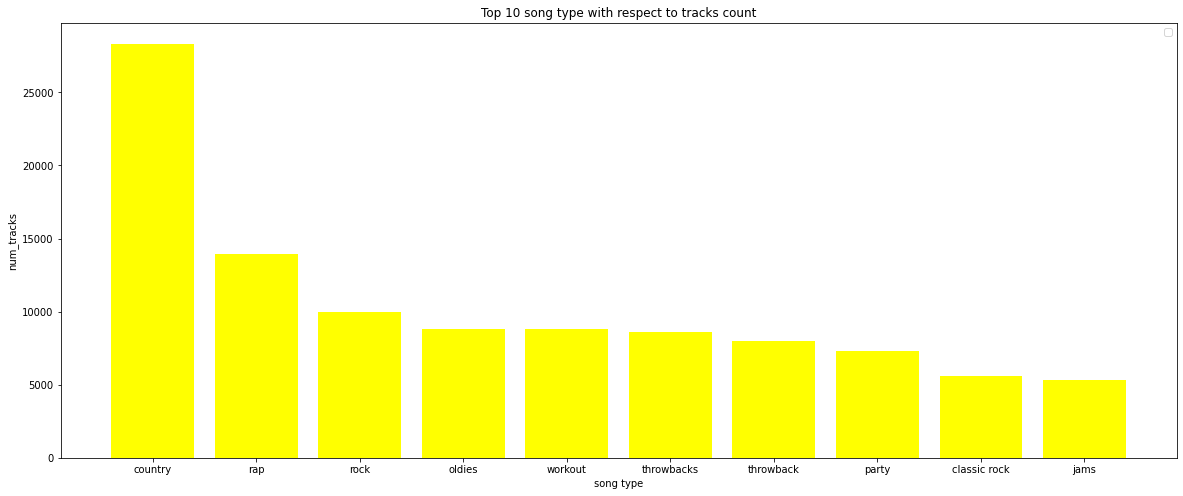

In [9]:
#select top 10 song types by number of tracks
data = df[['name', 'num_tracks']].groupby(['name']).sum('num_tracks').reset_index().sort_values(
                                                    by='num_tracks', ascending=False)
data = data[:10]

fig,ax = plt.subplots(1,1, figsize=(20, 8))
plt. bar(data['name'], data['num_tracks'], color='yellow')
plt.xlabel('song type')
plt.ylabel('num_tracks')
plt.title('Top 10 song type with respect to tracks count')
plt. legend()

Text(0.5, 0, 'Number of tracks')

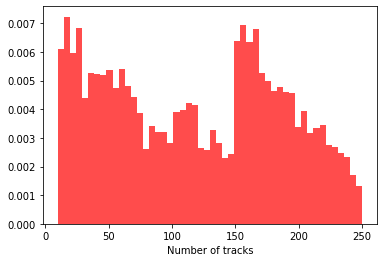

In [10]:
#distribution of number of tracks
_, _, _ = plt.hist(df['num_tracks'], 50,  density = 0.5, color ='red', alpha = 0.7)
plt.xlabel('Number of tracks')

In [11]:
df.head()

name  num_holdouts      pid  num_tracks  \
0         party            70  1000000          75   
1        school            73  1000016          78   
2  modern music            63  1000020          68   
3       lit 2.0            49  1000023          54   
4           bbq            71  1000040          76   

                                              tracks  num_samples  
0  [{'pos': 0, 'artist_name': 'AronChupa', 'track...            5  
1  [{'pos': 0, 'artist_name': 'Alesso', 'track_ur...            5  
2  [{'pos': 0, 'artist_name': 'Banks', 'track_uri...            5  
3  [{'pos': 0, 'artist_name': 'Galantis', 'track_...            5  
4  [{'pos': 0, 'artist_name': 'Stick Figure', 'tr...            5

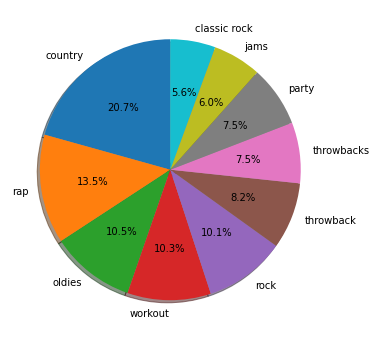

In [12]:
data = df['name'].value_counts()[:10].to_dict()

fig,ax = plt.subplots(1,1, figsize=(6,6))
_ = plt.pie(list(data.values()), labels=list(data.keys()), autopct='%1.1f%%',shadow=True, startangle=90)

In [13]:
#select n rows for further analysis
n_rows = 100
df = df[:n_rows]

In [15]:
df.shape

(100, 6)

In [16]:
# all songs track info
tracks_list = df['tracks'].to_list()

#2d to 1d list 
all_tracks = []
for li in tracks_list:
  all_tracks.extend(li)

#list to dataframe
all_tracks = pd.DataFrame(all_tracks)
all_tracks.head()

pos artist_name                             track_uri  \
0    0   AronChupa  spotify:track:66U0ASk1VHZsqIkpMjKX3B   
1    1   AronChupa  spotify:track:5MhsZlmKJG6X5kTHkdwC4B   
2    2       Lorde  spotify:track:0GZoB8h0kqXn7XFm4Sj06k   
3    3       Lorde  spotify:track:35kahykNu00FPysz3C2euR   
4    4       Lorde  spotify:track:3G6hD9B2ZHOsgf4WfNu7X1   

                              artist_uri  \
0  spotify:artist:5vCOdeiQt9LyzdI87kt5Sh   
1  spotify:artist:5vCOdeiQt9LyzdI87kt5Sh   
2  spotify:artist:163tK9Wjr9P9DmM0AVK7lm   
3  spotify:artist:163tK9Wjr9P9DmM0AVK7lm   
4  spotify:artist:163tK9Wjr9P9DmM0AVK7lm   

                                          track_name  \
0                                       Little Swing   
1                                   I'm an Albatraoz   
2  Yellow Flicker Beat - From The Hunger Games: M...   
3                                  White Teeth Teens   
4                                               Team   

                              album_uri  duration_ms           album_name  
0  spotify:album:4S5MLjwRSi0NJ5nikflYnZ       163809         Little Swing  
1  spotify:album:1qHVYbxQ6IS8YRviorKDJI       166848     I'm an Albatraoz  
2  spotify:album:4UEPxQx0cTcYNsE0n32MHV       232506  Yellow Flicker Beat  
3  spotify:album:0rmhjUgoVa17LZuS8xWQ3v       216600         Pure Heroine  
4  spotify:album:0rmhjUgoVa17LZuS8xWQ3v       193058         Pure Heroine

In [17]:
#drop dupllicate rows
all_tracks.drop_duplicates(subset=['track_name', 'artist_name'], inplace=True)

#unique track names
all_unique_tracks = all_tracks['track_uri'].unique()

In [ ]:
#extract features of all tracks
def extract_track_features(track_uri):

    client_credentials_manager = SpotifyClientCredentials(client_id='bc3b23ad498a4e838c387e9100cbf5fb', 
                                                          client_secret='88d9c75ed8a840ab88f0f1726f5a3b9e')
    sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)
    
    features = sp.audio_features(track_uri)[0]
    trk_p = sp.track(track_uri)["popularity"]
    artist = sp.track(track_uri)["artists"][0]["id"]
    features["artist_pop"] = sp.artist(artist)["popularity"]
    features["track_pop"] = trk_p
    print(features)

    #remove following info from dicionary
    for key in ['type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms', 'genres']:
      if key in list(features.keys()):
        del features[key]

    #returns all features related to a track
    return features

#extract all track features
all_unique_tracks_Data = []
for track_uri in all_unique_tracks:   
  all_unique_tracks_Data.append(extract_track_features(track_uri))

In [ ]:
#list to dataframe (track features)
all_tracks_info = pd.DataFrame(all_unique_tracks_Data)
all_tracks_info.head()

danceability  energy  key  loudness  mode  speechiness  acousticness  \
0         0.558   0.327    0   -10.974     1       0.0309        0.8890   
1         0.360   0.684    4    -6.457     0       0.0308        0.3230   
2         0.630   0.777    9    -3.965     0       0.0482        0.0267   
3         0.503   0.727    1    -5.456     1       0.1670        0.0159   
4         0.745   0.830    0    -6.558     1       0.0471        0.1100   

   instrumentalness  liveness  valence    tempo  time_signature  artist_pop  \
0          0.057600    0.2810    0.204   91.016               4          61   
1          0.000000    0.3400    0.200   77.150               4          73   
2          0.000002    0.1440    0.365  128.062               4          59   
3          0.000095    0.0895    0.521  121.985               4          72   
4          0.000019    0.0378    0.711  148.164               4          52   

   track_pop  
0          0  
1         74  
2         20  
3          0  
4         35

In [ ]:
#track uri column
all_tracks_info['track_uri'] = all_unique_tracks

#drop columns
all_tracks.drop(['pos', 'artist_uri', 'album_uri'], axis=1, inplace=True)

#merge dataframes
all_tracks = pd.merge(all_tracks_info, all_tracks, how='inner', on='track_uri')

In [ ]:
all_tracks.head()

danceability  energy  key  loudness  mode  speechiness  acousticness  \
0         0.558   0.327    0   -10.974     1       0.0309        0.8890   
1         0.360   0.684    4    -6.457     0       0.0308        0.3230   
2         0.630   0.777    9    -3.965     0       0.0482        0.0267   
3         0.503   0.727    1    -5.456     1       0.1670        0.0159   
4         0.745   0.830    0    -6.558     1       0.0471        0.1100   

   instrumentalness  liveness  valence    tempo  time_signature  artist_pop  \
0          0.057600    0.2810    0.204   91.016               4          61   
1          0.000000    0.3400    0.200   77.150               4          73   
2          0.000002    0.1440    0.365  128.062               4          59   
3          0.000095    0.0895    0.521  121.985               4          72   
4          0.000019    0.0378    0.711  148.164               4          52   

   track_pop                             track_uri   artist_name  \
0          0  spotify:track:4nLaeAathdcgAhhB0h5aWe          Rhye   
1         74  spotify:track:5Xak5fmy089t0FYmh3VJiY     Pearl Jam   
2         20  spotify:track:6grPoklV4nQYAxLsAury9j        Audien   
3          0  spotify:track:1BltsyC5W3SAABdxyrDXwi    Disclosure   
4         35  spotify:track:1YirIbC1vGEkaQiBrJqY0G  Citizen Cope   

                 track_name  duration_ms             album_name  
0                      Open       217053                  Woman  
1                     Black       342653                    Ten  
2  Leaving You - Radio Edit       214226  Leaving You (Remixes)  
3                     Latch       255631                 Settle  
4             Healing Hands       328724       The Rainwater Lp

In [ ]:
#new column, which is a combination of artist_name and track_name
all_tracks['artist_track_combo'] = all_tracks['artist_name']	+ '|' + all_tracks['track_name']

In [ ]:
all_tracks['artist_track_combo'].nunique(), all_tracks.shape

(484, (484, 3))

In [ ]:
#select numerical attributes, which represents a feature of track and artist
vectorizer = all_tracks[['danceability',	'energy',	'key',	'loudness',	'mode',	'speechiness',	'acousticness',	
                         'instrumentalness',	'liveness',	'valence',	'tempo',	'time_signature',	'artist_pop',	'track_pop',	
                         'duration_ms']]

#dataframe to numpy conversion
vectorizer = vectorizer.to_numpy()

all_tracks = all_tracks[['artist_name',	'track_name']]




In [ ]:

scaler = MinMaxScaler()
vectorizer = scaler.fit_transform(vectorizer)

In [ ]:
correlation_coeff = np.corrcoef(vectorizer)

In [ ]:
pearsoncorr_between_tracks = pd.DataFrame(correlation_coeff, columns=all_tracks['artist_track_combo'], index=all_tracks['artist_track_combo'])

In [ ]:
pearsoncorr_between_tracks.head()

artist_track_combo               Rhye|Open  Pearl Jam|Black  \
artist_track_combo                                            
Rhye|Open                         1.000000         0.091668   
Pearl Jam|Black                   0.091668         1.000000   
Audien|Leaving You - Radio Edit  -0.000556         0.599222   
Disclosure|Latch                  0.564080         0.189769   
Citizen Cope|Healing Hands        0.492438         0.275035   

artist_track_combo               Audien|Leaving You - Radio Edit  \
artist_track_combo                                                 
Rhye|Open                                              -0.000556   
Pearl Jam|Black                                         0.599222   
Audien|Leaving You - Radio Edit                         1.000000   
Disclosure|Latch                                        0.424532   
Citizen Cope|Healing Hands                              0.390957   

artist_track_combo               Disclosure|Latch  Citizen Cope|Healing Hands  \
artist_track_combo                                                              
Rhye|Open                                0.564080                    0.492438   
Pearl Jam|Black                          0.189769                    0.275035   
Audien|Leaving You - Radio Edit          0.424532                    0.390957   
Disclosure|Latch                         1.000000                    0.868863   
Citizen Cope|Healing Hands               0.868863                    1.000000   

artist_track_combo               Yandel|Encantadora  \
artist_track_combo                                    
Rhye|Open                                  0.237527   
Pearl Jam|Black                            0.351229   
Audien|Leaving You - Radio Edit            0.590497   
Disclosure|Latch                           0.686270   
Citizen Cope|Healing Hands                 0.792965   

artist_track_combo               DJ Casper|Cha Cha Slide - Hardino Mix  \
artist_track_combo                                                       
Rhye|Open                                                    -0.111552   
Pearl Jam|Black                                               0.290320   
Audien|Leaving You - Radio Edit                               0.876794   
Disclosure|Latch                                              0.348490   
Citizen Cope|Healing Hands                                    0.330583   

artist_track_combo               Aidonia|Bruki (Raw)  Cameo|Candy  \
artist_track_combo                                                  
Rhye|Open                                   0.504339    -0.251626   
Pearl Jam|Black                             0.116112     0.562206   
Audien|Leaving You - Radio Edit             0.555978     0.742198   
Disclosure|Latch                            0.819925     0.096505   
Citizen Cope|Healing Hands                  0.780836     0.266196   

artist_track_combo               Escala|Chi Mai  ...  Connor Pearson|That Way  \
artist_track_combo                               ...                            
Rhye|Open                              0.097122  ...                 0.601399   
Pearl Jam|Black                        0.149511  ...                 0.071160   
Audien|Leaving You - Radio Edit        0.120221  ...                 0.330092   
Disclosure|Latch                      -0.353724  ...                 0.782829   
Citizen Cope|Healing Hands            -0.340567  ...                 0.821880   

artist_track_combo               Two Feet|Go Fuck Yourself  \
artist_track_combo                                           
Rhye|Open                                         0.711511   
Pearl Jam|Black                                  -0.045590   
Audien|Leaving You - Radio Edit                   0.265855   
Disclosure|Latch                                  0.629142   
Citizen Cope|Healing Hands                        0.406560   

artist_track_combo               Jack Johnson|Banana Pancakes  \
artist_track_combo                                      